In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
# 定義日期區間
start = "2020-01-01"
end = "2024-12-31"

# 定義初始投資金額
portfolio_value = 1000000

# 定義資產代號
stock = '006208.TW'
bond = '00687B.TWO'
gold = '00708L.TW'

# 定義資產比重
stock_ratio = 0.7
bond_ratio = 0.15
gold_ratio = 0.15

# 定義再平衡週期
rebalance_cycle = 'day'

# 定義交易稅與手續費率
transaction_tax = 0.003  # 0.3%
transaction_fee = 0.001425  # 0.1425%

# 定期定額金額
add_value = 30000

In [3]:
# 下載資產價格資料
query = f'{stock} {bond} {gold}'
df_portfolio = yf.download(query, start = start, end = end, group_by = 'ticker')
df_TWII = yf.download("^TWII", start = start, end = end, group_by = 'ticker')

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# 獲取調整後的收盤價
df_portfolio = df_portfolio.xs('Adj Close', axis=1, level=1)
df_TWII = df_TWII.xs('Adj Close', axis=1, level=1)
df_TWII.columns = ['TWII']
df_portfolio.index.rename('Date', inplace=True)

In [5]:
# 計算TWII的累積報酬率
df_TWII_return = df_TWII['TWII'].pct_change()
cumulative_returns_TWII = (1 + df_TWII_return).cumprod() - 1

In [6]:
# 設定再平衡索引
if rebalance_cycle == 'year':
    rebalance_index = df_portfolio.index.year
elif rebalance_cycle == 'month':
    rebalance_index = df_portfolio.index.month
else:
    rebalance_index = df_portfolio.index.day
rebalance_index

Index([ 2,  3,  6,  7,  8,  9, 10, 13, 14, 15,
       ...
       19, 20, 21, 22, 25, 26, 27, 28, 29,  2],
      dtype='int32', name='Date', length=1194)

In [7]:
# 初始化結果
weights = np.array([stock_ratio, bond_ratio, gold_ratio])
allocated_value = (portfolio_value * weights).round(0)
portfolio_values = [portfolio_value]
# print(f"init: {portfolio_value=}")
# print(f"init: {allocated_value=}")
# print(f"init: ratio={allocated_value / sum(allocated_value)}\n")

for i in range(1, len(df_portfolio)):
    # 是否需要再平衡
    if rebalance_index[i] != rebalance_index[i - 1]:
        # 平衡的狀態下應該有的持有價值
        allocated_value_balanced = ((portfolio_value + add_value) * weights).round(0)
        # print(f"init: {portfolio_value=}")
        # print(f"init: {allocated_value=}")

        # 計算需要交易的金額
        trade_values = allocated_value_balanced - allocated_value

        # 賣出金額 (先賣出再買入，避免資金不足)
        sell_values = trade_values[trade_values < 0]  # 賣出金額（負值）
        sell_adjusted = (np.abs(sell_values) * (1 - transaction_tax - transaction_fee)).round(0) # 賣出後的實際收入（扣除交易稅與手續費）

        # 買入金額
        buy_values = trade_values[trade_values > 0] # 買入金額（正值）
        buy_adjusted = (buy_values / sum(buy_values) * sum(sell_adjusted)).round(0) # 因應賣出交易成本按比例調整買入金額
        buy_adjusted = (buy_adjusted * (1 - transaction_fee)).round(0) # 買入的實際資產金額 (扣除手續費)

        # 更新資產分配
        allocated_value[trade_values < 0] += sell_values # 賣出後的資產價值 (負值)
        allocated_value[trade_values > 0] += buy_adjusted # 買入後的資產價值

        # 更新再平衡後的資產價值
        portfolio_value = allocated_value.sum()        

        # print(f"{allocated_value_balanced=}")
        # print(f"{trade_values.values=}")
        # print(f"{sell_values.values=}")
        # print(f"{sell_adjusted.values=}")
        # print(f"{buy_values.values=}")
        # print(f"{buy_adjusted.values=}")
        # print(f"rebalance: {allocated_value=}")
        # print(f"rebalance: {portfolio_value=}")
        # print(f"rebalance ratio={(allocated_value / sum(allocated_value))}\n")

    # 計算當日報酬
    daily_return = (df_portfolio.iloc[i] / df_portfolio.iloc[i-1]) - 1
    allocated_value = allocated_value + (allocated_value * daily_return).round(0)
    
    # 更新當日投資組合價值
    portfolio_value = allocated_value.sum()
    portfolio_values.append(round(portfolio_value))
    # print(f"{portfolio_value=}")
    # print(f"{allocated_value=}")
    # print(f"ratio={(allocated_value / sum(allocated_value)).values}\n\n")

# 將投資組合價值轉為 DataFrame
df_portfolio_values = pd.DataFrame(portfolio_values, index=df_portfolio.index, columns=['Portfolio'])

# 計算累積報酬率
df_portfolio_return = df_portfolio_values['Portfolio'].pct_change()
cumulative_returns_portfolio = (1 + df_portfolio_return).cumprod() - 1

In [8]:
# 合併結果
df_returns = pd.concat([cumulative_returns_portfolio, cumulative_returns_TWII], axis=1)
df_returns.resample('YE').last()

,Portfolio,TWII
Date,,
2020-12-31 00:00:00+00:00,0.315973,0.217516
2021-12-31 00:00:00+00:00,0.211357,0.505629
2022-12-31 00:00:00+00:00,0.101217,0.168358
2023-12-31 00:00:00+00:00,0.255744,0.481826
2024-12-31 00:00:00+00:00,0.724804,0.879010


In [9]:
df_compare = pd.DataFrame(df_returns.iloc[-1].values.reshape(1, -1), columns = df_returns.columns + "(%)", index = ['報酬率'])
df_compare = (df_compare * 100).round(2)
df_compare

,Portfolio(%),TWII(%)
報酬率,72.48,87.9


In [10]:
def calculate_max_drawdown(returns):
    """計算最大跌幅"""
    cumulative_returns = (1 + returns).cumprod() # 計算累積收益
    rolling_max = cumulative_returns.cummax() # 計算歷史最大累積收益
    drawdown = (cumulative_returns - rolling_max) / rolling_max # 計算當前值與過去最高點之間的差距來得出最大跌幅
    max_drawdown = drawdown.min() # 最大跌幅(負最小值)
    return round(max_drawdown * 100, 2)

def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=252):
    """計算夏普比率"""
    excess_returns = returns - (risk_free_rate / periods_per_year) # 超額報酬 = 收益率 - 無風險利率(日)
    sharpe_ratio =  (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)) # sharpe_ratio = (超額報酬平均值(日) * n) / (標準差(日) * 根號n)，n為一年交易日
    return round(sharpe_ratio * 100, 2)

# 假設 df_portfolio_return 和 df_TWII_return 已經計算好了
# 計算最大跌幅
max_drawdown_portfolio = calculate_max_drawdown(df_portfolio_return)
max_drawdown_TWII = calculate_max_drawdown(df_TWII_return)

# 計算夏普比率
sharpe_ratio_portfolio = calculate_sharpe_ratio(df_portfolio_return)
sharpe_ratio_TWII = calculate_sharpe_ratio(df_TWII_return)

df_compare.loc['最大跌幅'] = [max_drawdown_portfolio, max_drawdown_TWII]
df_compare.loc['Sharpe Ratio'] = [sharpe_ratio_portfolio, sharpe_ratio_TWII]
df_compare

,Portfolio(%),TWII(%)
報酬率,72.48,87.90
最大跌幅,-38.11,-31.63
Sharpe Ratio,52.00,69.88


In [11]:
df_portfolio_scale = (df_portfolio - df_portfolio.min()) / (df_portfolio.max() - df_portfolio.min())

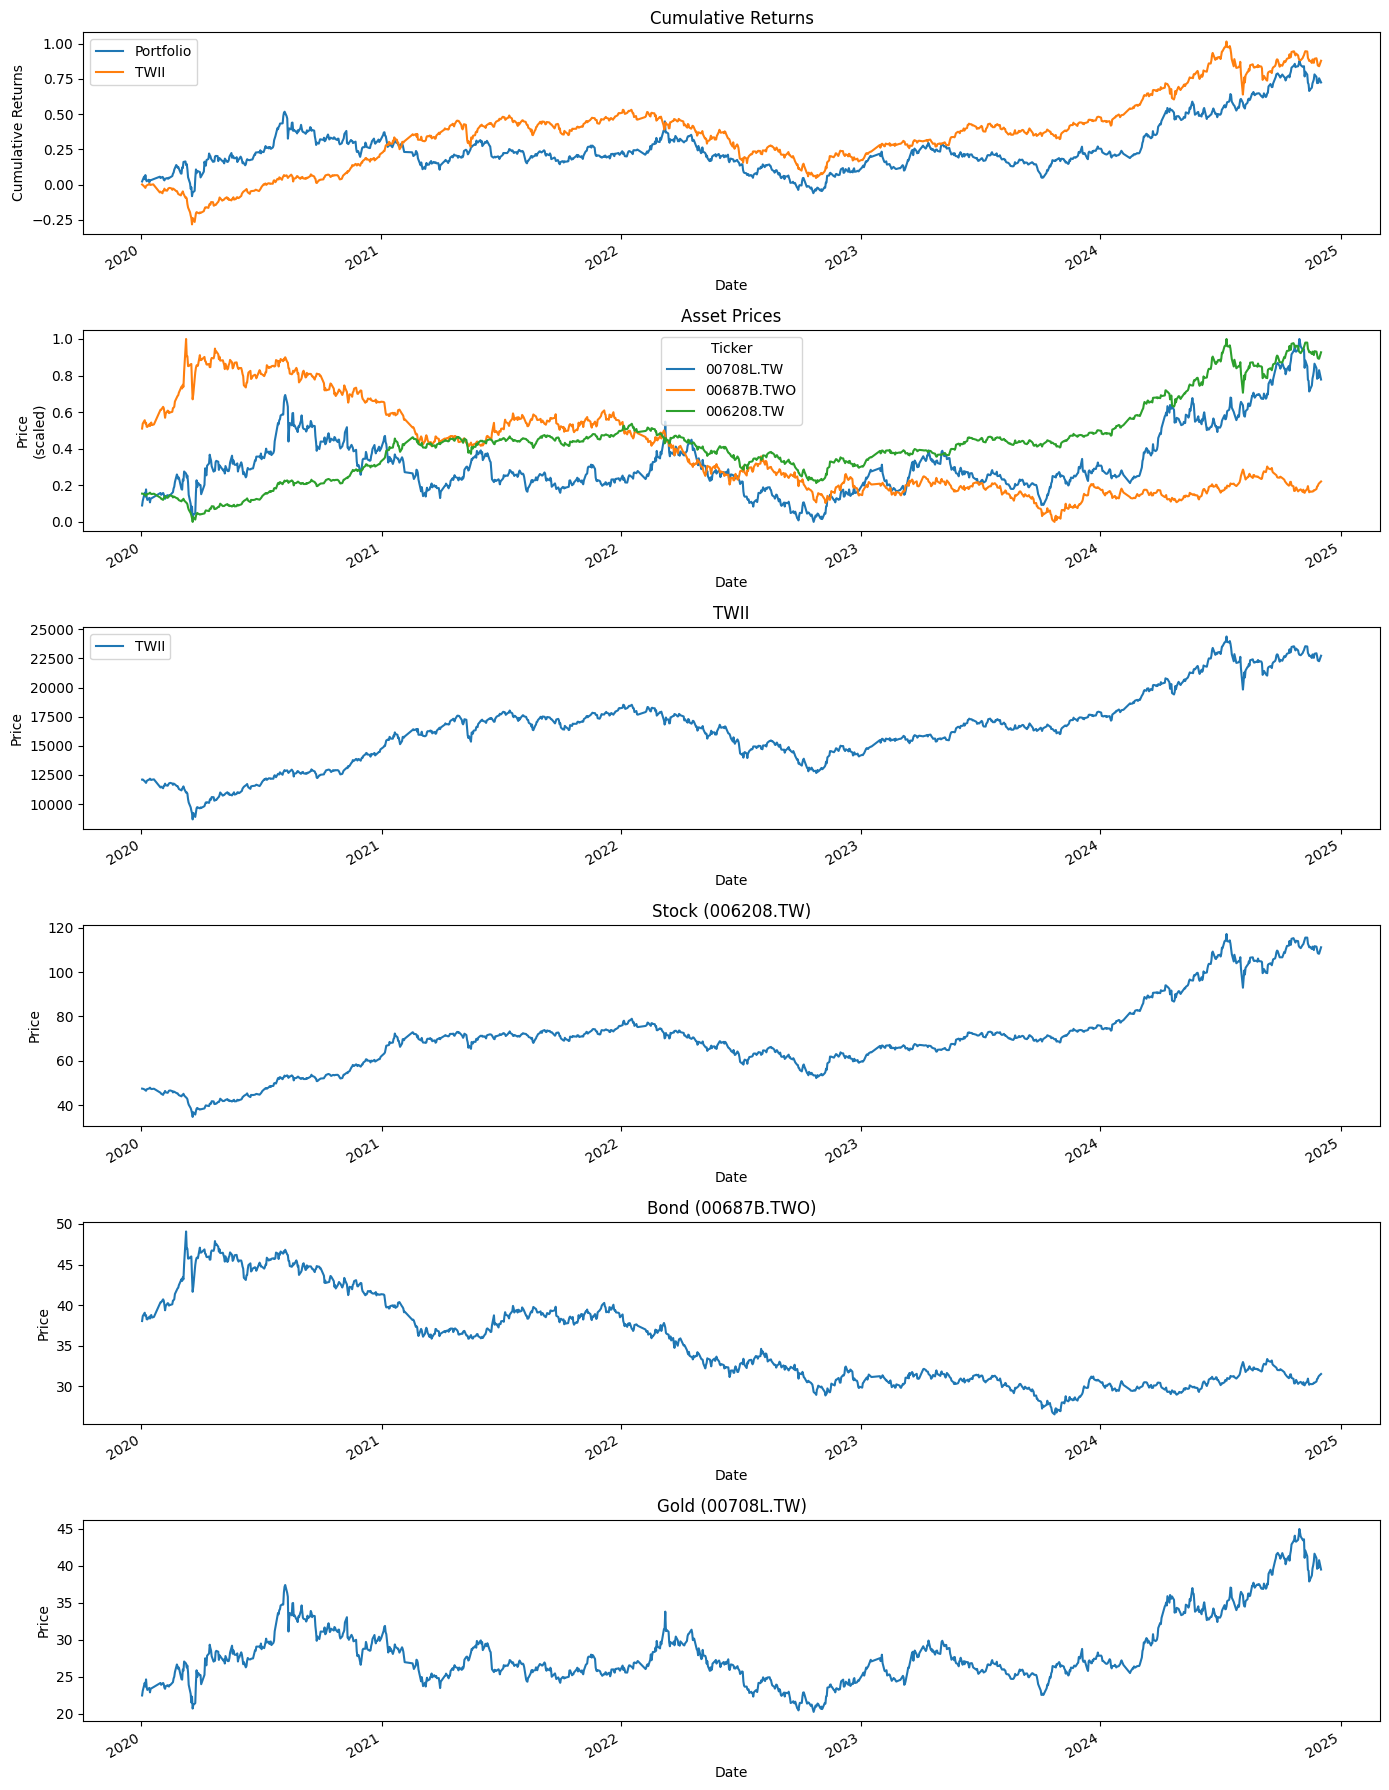

In [12]:
import matplotlib.pyplot as plt

total_plot = 6

# 繪製股價走勢圖
plt.figure(figsize=(14, total_plot * 3))

# 投資組合的累積回報
plt.subplot(total_plot, 1, 1)
df_returns.plot(ax=plt.gca())
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Returns')

# 三個資產的走勢
plt.subplot(total_plot, 1, 2)
df_portfolio_scale.plot(ax=plt.gca())
plt.title('Asset Prices')
plt.ylabel('Price\n(scaled)')

# stock 的價格走勢
plt.subplot(total_plot, 1, 3)
df_TWII.plot(ax=plt.gca())
plt.title('TWII')
plt.ylabel('Price')

# stock 的價格走勢
plt.subplot(total_plot, 1, 4)
df_portfolio[stock].plot(ax=plt.gca())
plt.title(f'Stock ({stock})')
plt.ylabel('Price')

# bond 的價格走勢
plt.subplot(total_plot, 1, 5)
df_portfolio[bond].plot(ax=plt.gca())
plt.title(f'Bond ({bond})')
plt.ylabel('Price')

# gold 的價格走勢
plt.subplot(total_plot, 1, 6)
df_portfolio[gold].plot(ax=plt.gca())
plt.title(f'Gold ({gold})')
plt.ylabel('Price')

plt.tight_layout()
plt.show()